In [1]:
import pandas as pd
import nltk
import torch.nn as nn
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from matplotlib import pyplot as plt



In [2]:

# Replace 'your_file.csv' with the actual path to your CSV file
file_path_train = 'data/train.csv'
file_path_test = 'data/test.csv'

# Read the CSV file into a DataFrame
df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

In [3]:
df_test.head()

,topic,hashtag,content,hashtag_related 1,hashtag_related 2,hashtag_related 3,hashtag_related 4,hashtag_related 5,author,create_at
0,Lifestyle,Lifehack,beauty lifehack save on makeup remover us...,#lifehack,NaN,NaN,NaN,NaN,martinenyx,2023-11-13 00:44:13+00:00
1,News,BreakingNews,reuters ukraine says russians intensify bomb...,#WNN7,#WorldNewsNuggets,NaN,NaN,NaN,WNN7,2023-11-14 02:09:09.048000+00:00
2,Technology,Technology,the residency imagining robots at waag futurel...,#eudigitaldeal,#opencall,#creativeeurope,#artistresidencies,#ai,waag,2023-11-14 12:07:06+00:00
3,Travel,Tourism,tal grazzja 🇲🇹 malta 2006 📷shot © bianca...,#autobus,#bus,#transports,#malta,#europe,salvomic,2023-11-13 16:40:38+00:00
4,Environment,Nature,green snake on a tree branch photography n...,#photography,#nature,#naturephotography,#wildlife,#snake,PatrickReedPhotography,2023-11-14 15:31:36.584000+00:00


In [4]:
print("Number of training examples: ", df_train.shape[0])
print("Number of testing examples: ", df_test.shape[0])

Number of training examples:  2088
Number of testing examples:  523


In [5]:
df_train['topic'].value_counts()

Health             160
Travel             155
Education          154
Environment        151
Politics           150
Entertainment      148
Humor              148
Science            144
Lifestyle          140
Technology         134
Sports             133
Art and Culture    131
Fashion            131
News               113
Food                96
Name: topic, dtype: int64

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    

In [20]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

texts = df_train['content'].tolist()
labels = df_train['topic'].tolist()
# Preprocess texts
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

texts = [preprocess(text) for text in texts]

tests_test = df_test['content'].tolist()
tests_test = [preprocess(text) for text in tests_test]
labels_test = df_test['topic'].tolist()


## Don't use the pre-trained word2vec model

In [23]:

vector_size = 200



# Train Word2Vec or load a pre-trained model
model_word2vec = Word2Vec([text.split() for text in texts], vector_size=vector_size, window=50, min_count=1, workers=4, sg=1, epochs=100)
# model = Word2Vec.load("path_to_pretrained_model")  # If using a pre-trained model
# Vectorize sentences
def sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)



In [24]:
X = np.array([sentence_vector(text, model_word2vec) for text in texts])

# Prepare labels
labels = df_train['topic'].tolist()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

X_test = np.array([sentence_vector(text, model_word2vec) for text in tests_test])
y_test = label_encoder.transform(labels_test)

In [10]:
X.shape

(2088, 200)

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.norm = nn.BatchNorm1d(input_size)
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size, num_classes)  # Ensure num_classes matches the number of categories

    def forward(self, x):
        x = self.norm(x)
        out = self.layer1(x)
        out = self.relu1(out)
        out = self.layer2(out)
        out = self.relu2(out)
        out = self.layer3(out)
        return out

# Initialize MLP with the correct number of output classes
input_size = vector_size
hidden_size = 32
mlp = MLP(input_size, hidden_size, 15)  # Adjust input_size and hidden_size as per your data


In [28]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

In [11]:
from sklearn.model_selection import KFold

def train(epochs, train_loader, test_loader, mlp, criteria, optimizer):
    train_losses = []
    test_losses = []
    train_precisions = []
    test_precisions = []


    for epoch in range(epochs):
        loss_train = 0
        precision_train = 0
        for i, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.float()
            outputs = mlp(data)
            loss = criteria(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            precision_train += (outputs.argmax(dim=1) == labels).float().mean()
        loss_train /= len(train_loader)
        precision_train /= len(train_loader)

        loss_test = 0
        precision_test = 0
        with torch.no_grad():  # No gradient calculation in evaluation
            for i, (data, labels) in enumerate(test_loader):
                data = data.float()
                outputs = mlp(data)
                loss = criteria(outputs, labels)
                loss_test += loss.item()
                precision_test += (outputs.argmax(dim=1) == labels).float().mean()
        loss_test /= len(test_loader)
        precision_test /= len(test_loader)
        print(f'Epoch {epoch+1}: train loss: {loss_train}, train precision: {precision_train} test loss: {loss_test}, test precision: {precision_test}')
        train_losses.append(loss_train)
        test_losses.append(loss_test)
        train_precisions.append(precision_train)
        test_precisions.append(precision_test)
    return train_losses, test_losses, train_precisions, test_precisions


In [12]:
# Plot losses and precisions
import matplotlib.pyplot as plt

def affichage(train_losses, test_losses, train_precisions, test_precisions):
    for i in range(len(train_losses)):
        plt.plot(train_losses[i], alpha=0.3)
        plt.plot(test_losses[i], alpha=0.3)
        plt.xlabel('epochs')
        plt.ylabel('loss')
    plt.plot(np.mean(train_losses, axis=0), label='mean train loss')
    plt.plot(np.mean(test_losses, axis=0), label='mean test loss')

    plt.legend()
    plt.savefig('image/loss.png')
    plt.show()
    for i in range(len(train_precisions)):
        plt.plot(train_precisions[i], alpha=0.3)
        plt.plot(test_precisions[i], alpha=0.3)
        plt.xlabel('epochs')
        plt.ylabel('precision')
    plt.plot(np.mean(train_precisions, axis=0), label='mean train precision')
    plt.plot(np.mean(test_precisions, axis=0), label='mean test precision')
    plt.legend()
    plt.savefig('image/precision.png')
    plt.show()




In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.norm = nn.BatchNorm1d(input_size)
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        # self.dropout = nn.Dropout(0.2)
        self.layer2 = nn.Linear(hidden_size, num_classes)  # Ensure num_classes matches the number of categories

    def forward(self, x):
        out = self.norm(x)
        out = self.layer1(x)
        out = self.relu1(out)
        # out = self.dropout(out)
        out = self.layer2(out)
        return out

# Initialize MLP with the correct number of output classes
input_size = vector_size
hidden_size = 32


In [14]:

def cross_validation(epochs, MLP,X, y, k=5, lr = 0.001,hidden_size=32, input_size=vector_size, batch_size=32):
    train_losses = []
    test_losses = []
    train_precisions = []
    test_precisions = []
    i = 0
    kf = KFold(n_splits=k, shuffle=True)
    
    models = []
    for train_index, test_index in kf.split(X):
        print(f'Fold {i+1}')
        i += 1
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        train_dataset = Dataset(X_train, y_train)
        test_dataset = Dataset(X_test, y_test)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        # Initialize MLP with the correct number of output classes

        model = MLP(input_size, hidden_size, 15)
        criteria = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        
        train_loss, test_loss, train_precision, test_precision = train(epochs, train_loader, test_loader, model, criteria, optimizer)
        models.append(model)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_precisions.append(train_precision)
        test_precisions.append(test_precision)
    return train_losses, test_losses, train_precisions, test_precisions, models

In [15]:
X.shape

(2088, 200)

In [16]:
X[:-5,:].shape

(2083, 200)

Fold 1
Epoch 1: train loss: 2.69598708152771, train precision: 0.10189393907785416 test loss: 2.6766861352053555, test precision: 0.18506494164466858
Epoch 2: train loss: 2.642075876756148, train precision: 0.2136363685131073 test loss: 2.6172341866926714, test precision: 0.2690746784210205
Epoch 3: train loss: 2.5692333828319205, train precision: 0.3323863744735718 test loss: 2.543314955451272, test precision: 0.3400973975658417
Epoch 4: train loss: 2.4820173436945137, train precision: 0.39753788709640503 test loss: 2.452650091864846, test precision: 0.4107142686843872
Epoch 5: train loss: 2.3780799518931994, train precision: 0.47746211290359497 test loss: 2.3506780537691983, test precision: 0.4606330990791321
Epoch 6: train loss: 2.267544785412875, train precision: 0.5189393758773804 test loss: 2.2370439876209605, test precision: 0.5004058480262756
Epoch 7: train loss: 2.1444811951030385, train precision: 0.5939394235610962 test loss: 2.1223231337287207, test precision: 0.57873374223

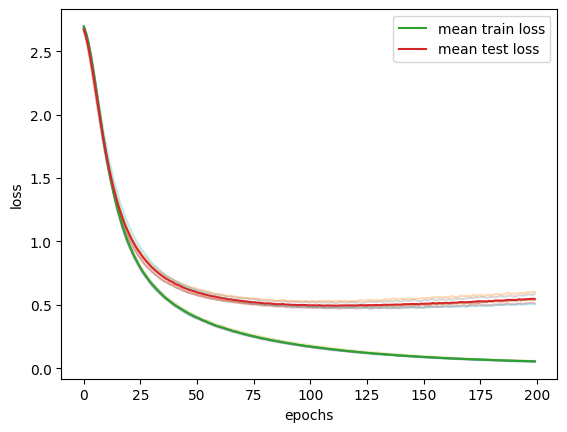

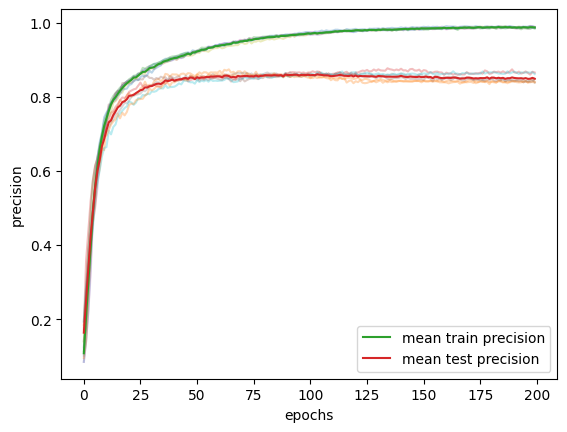

In [25]:


train_losses, test_losses, train_precisions, test_precisions, models = cross_validation(200, MLP,X, y, k=6, lr = 0.0003,hidden_size=32, input_size=vector_size,batch_size=32)

plt.figure()
affichage(train_losses, test_losses, train_precisions, test_precisions)

In [26]:
# calculate accuracy
from sklearn.metrics import accuracy_score
precision = 0.0
for model in models:
    precision += accuracy_score(y, model(torch.Tensor(X)).argmax(dim=1).numpy())
precision /= len(models)
print(f'Precision: {precision}')


Precision: 0.9661558109833971


In [28]:
# calculate accuracy
from sklearn.metrics import accuracy_score
precision = 0.0
for model in models:
    precision += accuracy_score(y_test, model(torch.Tensor(X_test)).argmax(dim=1).numpy())
precision /= len(models)
print(f'Precision: {precision}')


Precision: 0.8342893562778838


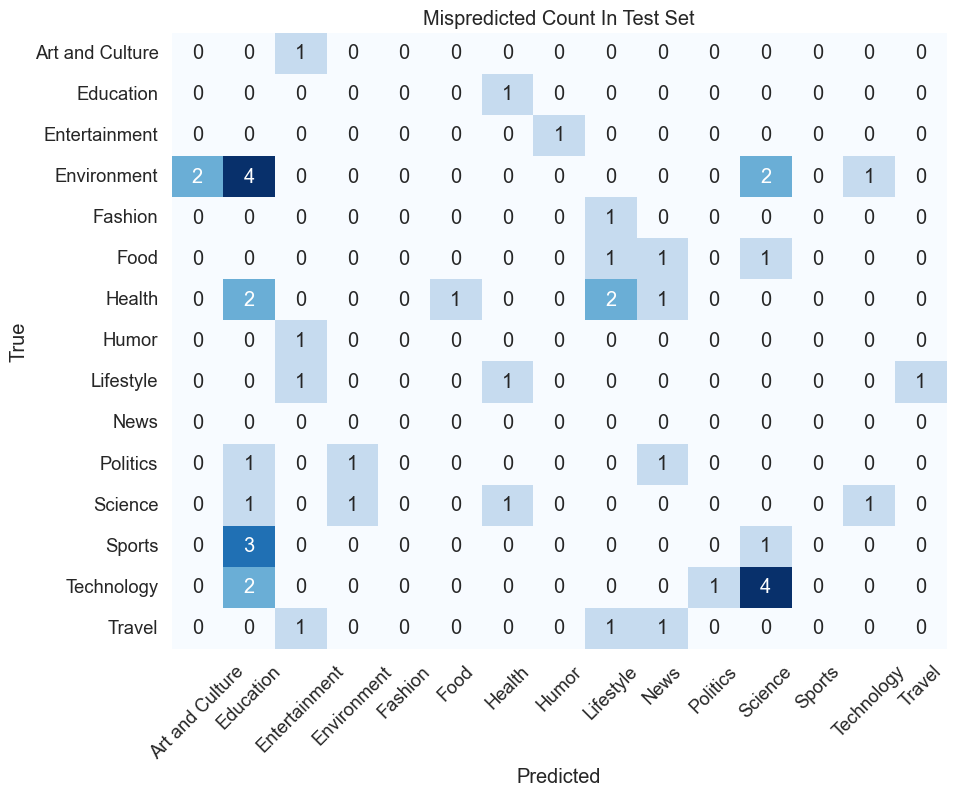

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = np.zeros((15, 15))
for mlp in models:
    conf_matrix += confusion_matrix(y_test, mlp(torch.tensor(X_test).float()).argmax(dim=1).numpy())

conf_matrix = conf_matrix.astype('float') /6.
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count In Test Set')
plt.xticks(rotation=45)
plt.savefig("image/MLP Test Mispredicted")
plt.show()


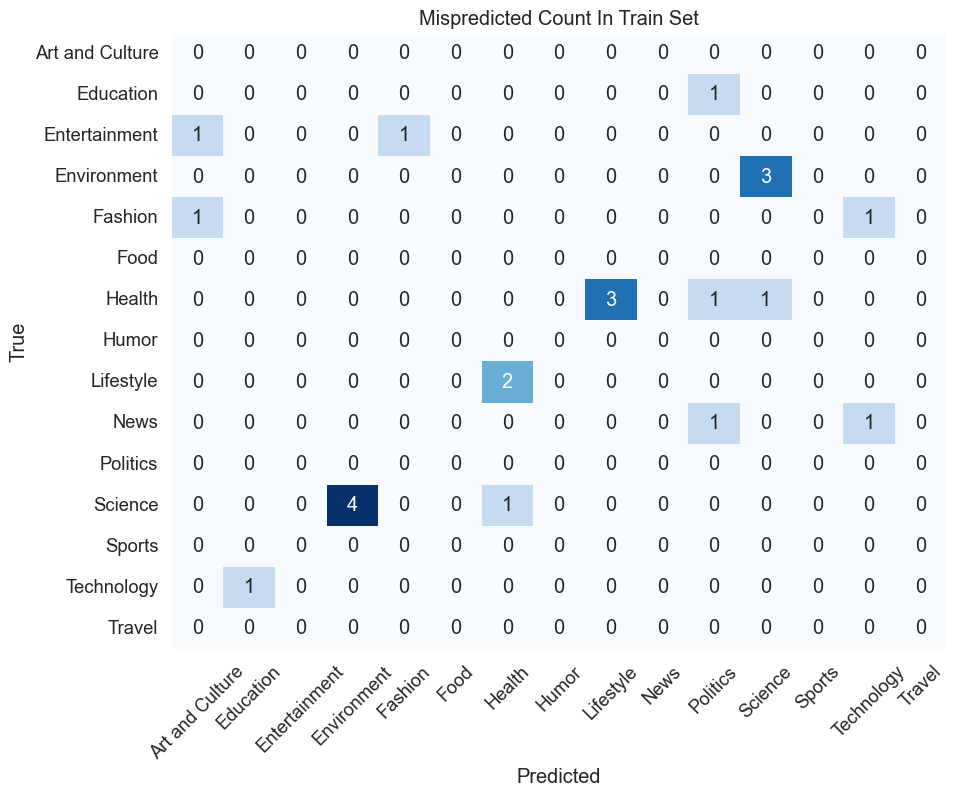

In [37]:
conf_matrix = np.zeros((15, 15))
for mlp in models:
    conf_matrix += confusion_matrix(y, mlp(torch.tensor(X).float()).argmax(dim=1).numpy())

conf_matrix = conf_matrix.astype('float') /6.
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count In Train Set')
plt.xticks(rotation=45)
plt.savefig("MLP Mispredicted")
plt.show()

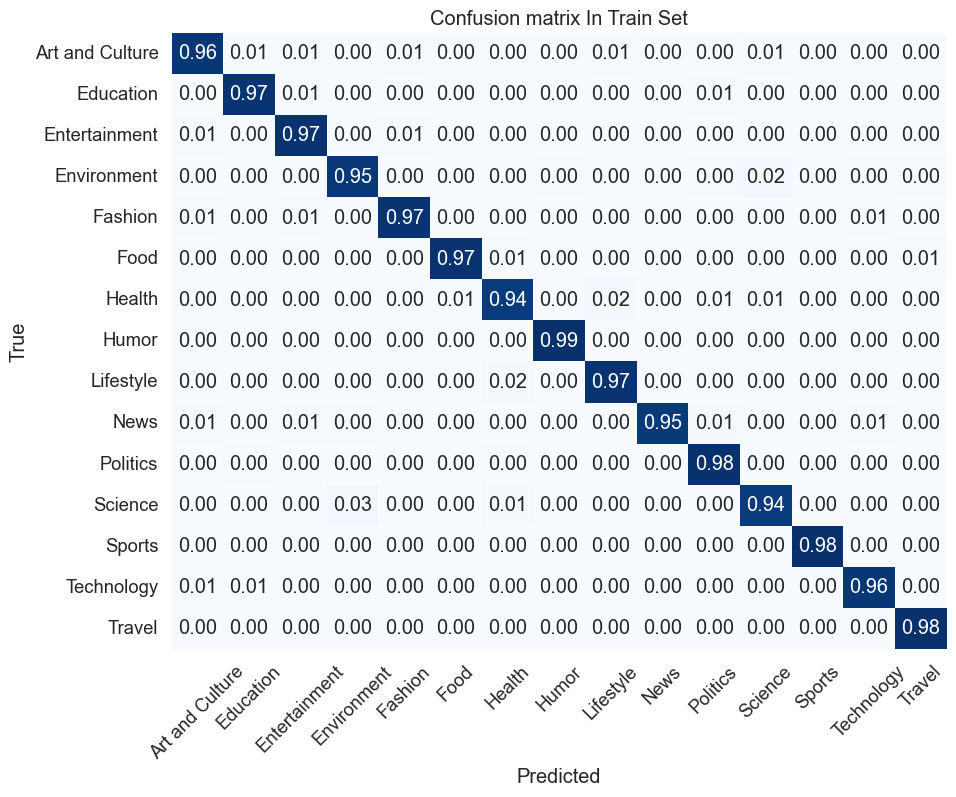

In [38]:
conf_matrix = np.zeros((15, 15))
for mlp in models:
    conf_matrix += confusion_matrix(y, mlp(torch.tensor(X).float()).argmax(dim=1).numpy())

# 将混淆矩阵进行归一化
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True,fmt=".2f", cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix In Train Set')
plt.xticks(rotation=45)
plt.savefig("image/Train MLP CM")
plt.show()

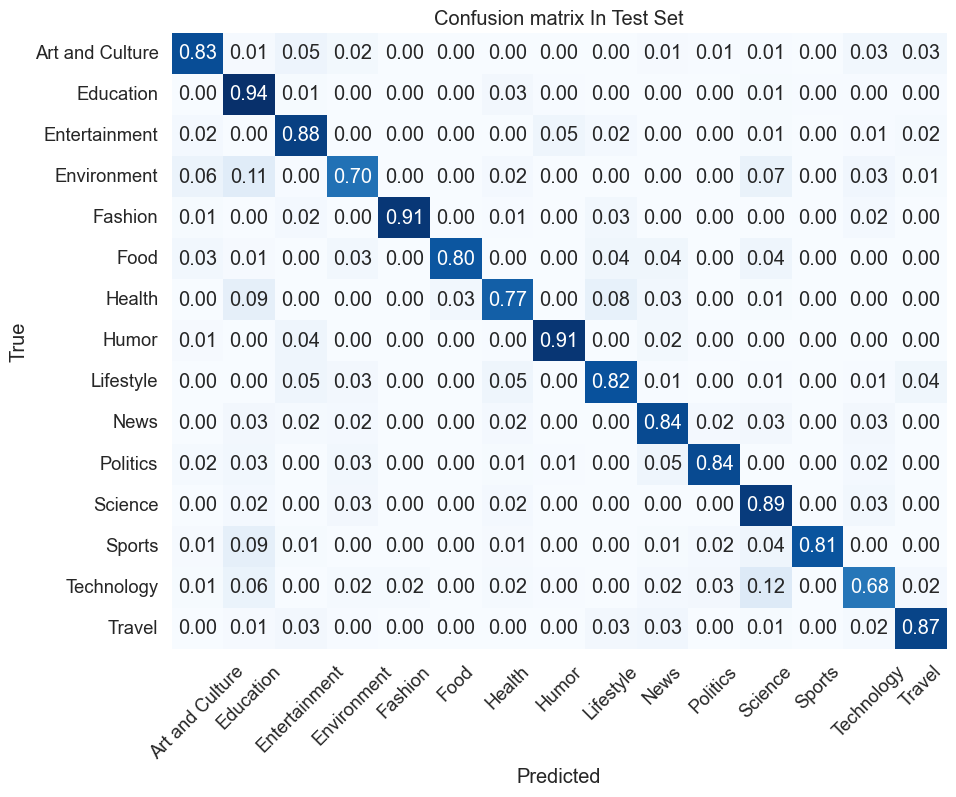

In [39]:
conf_matrix = np.zeros((15, 15))
for mlp in models:
    conf_matrix += confusion_matrix(y_test, mlp(torch.tensor(X_test).float()).argmax(dim=1).numpy())

# 将混淆矩阵进行归一化
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True,fmt=".2f", cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix In Test Set')
plt.xticks(rotation=45)
plt.savefig("image/Test MLP CM")
plt.show()

In [33]:
label_encoder.classes_

array(['Art and Culture', 'Education', 'Entertainment', 'Environment',
       'Fashion', 'Food', 'Health', 'Humor', 'Lifestyle', 'News',
       'Politics', 'Science', 'Sports', 'Technology', 'Travel'],
      dtype='<U15')

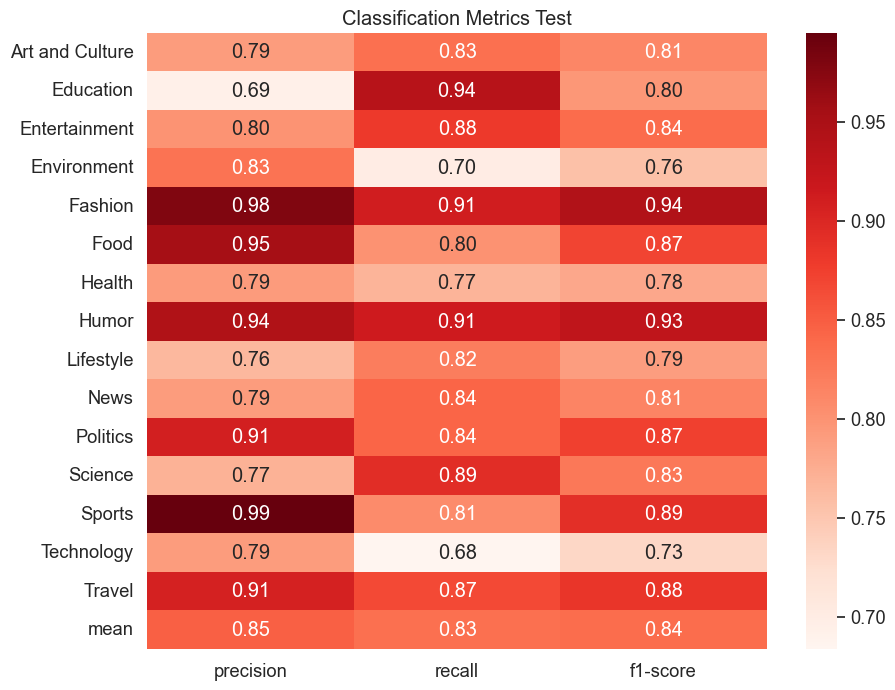

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Calculate precision, recall, and f1-score for each category
precision = np.zeros(15)
recall = np.zeros(15)
f1 = np.zeros(15)

for mlp in models:
    res = precision_recall_fscore_support(y_test, mlp(torch.tensor(X_test).float()).argmax(dim=1).numpy())
    precision += res[0]
    recall += res[1]
    f1 += res[2]

precision /= 6.
recall /= 6.
f1 /= 6.

precision_mean = precision.mean()
recall_mean = recall.mean()
f1_mean = f1.mean()

precision = np.append(precision, precision_mean)
recall = np.append(recall, recall_mean)
f1 = np.append(f1, f1_mean)

# Calculate accuracy
accuracy = np.diag(f1).sum() / f1.sum()

# Combine the metrics into a single 2D array
metrics = np.array([precision, recall, f1]).T

# Assuming you have category names in the same order as the labels

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap='Reds',
            xticklabels=['precision', 'recall', 'f1-score'], 
            yticklabels=np.append(label_encoder.classes_,'mean'))
plt.title('Classification Metrics Test')
plt.savefig("image/MLP Metrics")
plt.show()


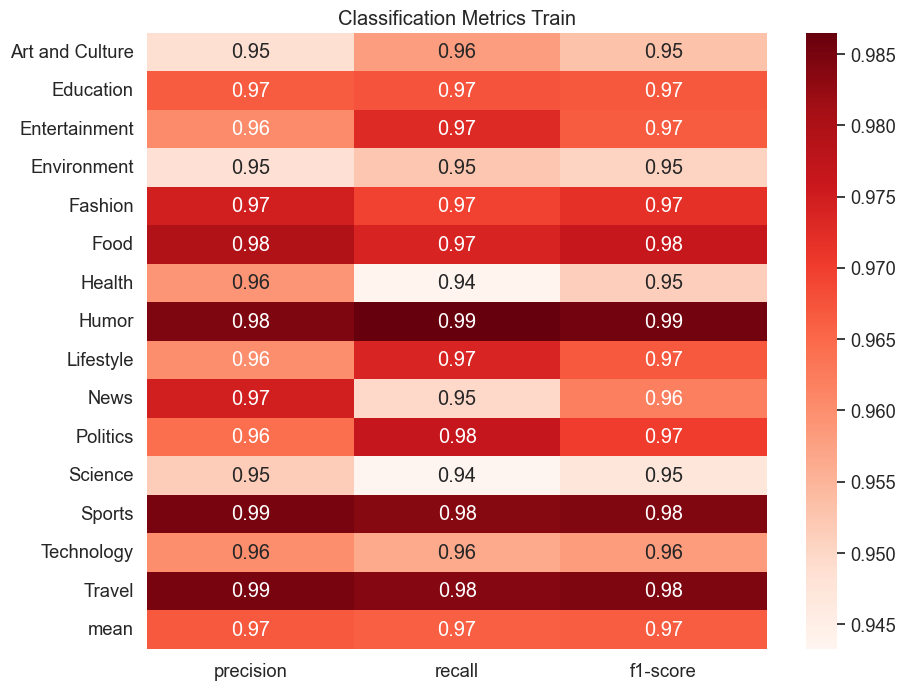

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Calculate precision, recall, and f1-score for each category
precision = np.zeros(15)
recall = np.zeros(15)
f1 = np.zeros(15)

for mlp in models:
    res = precision_recall_fscore_support(y, mlp(torch.tensor(X).float()).argmax(dim=1).numpy())
    precision += res[0]
    recall += res[1]
    f1 += res[2]

precision /= 6.
recall /= 6.
f1 /= 6.

precision_mean = precision.mean()
recall_mean = recall.mean()
f1_mean = f1.mean()

precision = np.append(precision, precision_mean)
recall = np.append(recall, recall_mean)
f1 = np.append(f1, f1_mean)

# Calculate accuracy
accuracy = np.diag(f1).sum() / f1.sum()

# Combine the metrics into a single 2D array
metrics = np.array([precision, recall, f1]).T

# Assuming you have category names in the same order as the labels

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap='Reds',
            xticklabels=['precision', 'recall', 'f1-score'], 
            yticklabels=np.append(label_encoder.classes_,'mean'))
plt.title('Classification Metrics Train')
plt.savefig("image/MLP Train Metrics")
plt.show()


In [252]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.layer2 = nn.Linear(hidden_size, num_classes)  # Ensure num_classes matches the number of categories

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.layer2(out)
        return out

# Initialize MLP with the correct number of output classes
input_size = vector_size
hidden_size = 64
mlp = MLP(input_size, hidden_size, 15)  # Adjust input_size and hidden_size as per your data


In [253]:

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

Epoch 1: train loss: 1.1529731244751902, train precision: 0.6306818127632141 test loss: 1.529999918407864, test precision: 0.5530303120613098
Epoch 2: train loss: 1.149085622845274, train precision: 0.6301136612892151 test loss: 1.6426733334859211, test precision: 0.5230429172515869
Epoch 3: train loss: 1.1445746927550344, train precision: 0.6303030252456665 test loss: 1.499376999007331, test precision: 0.5516098141670227
Epoch 4: train loss: 1.1742993177789631, train precision: 0.6135416626930237 test loss: 1.5961116817262437, test precision: 0.5429292917251587
Epoch 5: train loss: 1.151215049353513, train precision: 0.6221590638160706 test loss: 1.6184819009568956, test precision: 0.4970012903213501
Epoch 6: train loss: 1.1691569433067783, train precision: 0.6307764649391174 test loss: 1.513248364130656, test precision: 0.5776515007019043
Epoch 7: train loss: 1.1523576071768096, train precision: 0.6163825988769531 test loss: 1.5561737087037828, test precision: 0.5561869144439697
Epoc

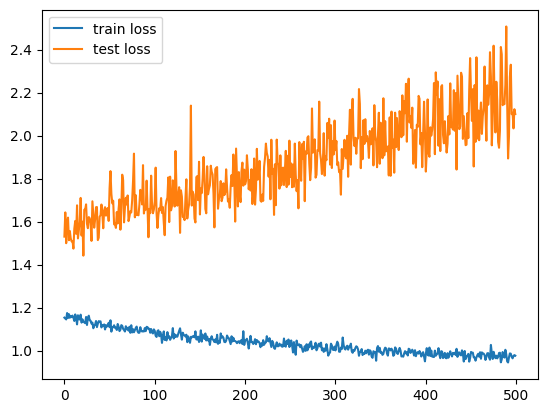

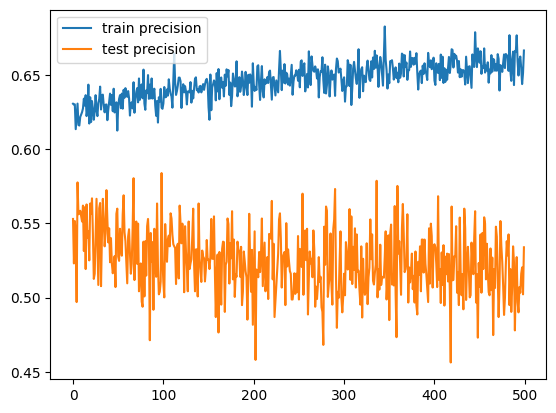

In [183]:
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

train_losses, test_losses, train_precisions, test_precisions = train(500, train_loader, test_loader, mlp, criteria, optimizer)
affichage(train_losses, test_losses, train_precisions, test_precisions)

# LSTM


In [11]:
vector_size = 300

# Preprocess texts
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

texts = [preprocess(text) for text in texts]
max_len = 512

# Train Word2Vec or load a pre-trained model
# model = Word2Vec.load("path_to_pretrained_model")  # If using a pre-trained model
model = word2vec_google_news
# Vectorize sentences
def sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = []
    for i in range(max_len):
        word = words[i] if i < len(words) else ''
        try:
            word_vectors.append(model[word])
        except KeyError:
            pass
    # word_vectors = [model[word] for word in words if model.key_to_index[word]]
    if len(word_vectors) < max_len:
        word_vectors += [np.zeros(model.vector_size)] * (max_len - len(word_vectors))

    return word_vectors



In [12]:
X = np.array([sentence_vector(text, model) for text in texts])

# Prepare labels
labels = df['topic'].tolist()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [22]:
X_train.shape

(2088, 2576, 300)

: 

In [32]:


def train(epochs, train_loader, test_loader, model, criteria, optimizer):
    train_losses = []
    test_losses = []
    train_precisions = []
    test_precisions = []


    for epoch in range(epochs):
        loss_train = 0
        precision_train = 0
        for i, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.float()
            outputs = model(data)
            loss = criteria(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            precision_train += (outputs.argmax(dim=1) == labels).float().mean()
        loss_train /= len(train_loader)
        precision_train /= len(train_loader)

        loss_test = 0
        precision_test = 0
        with torch.no_grad():  # No gradient calculation in evaluation
            for i, (data, labels) in enumerate(test_loader):
                data = data.float()
                outputs = model(data)
                loss = criteria(outputs, labels)
                loss_test += loss.item()
                precision_test += (outputs.argmax(dim=1) == labels).float().mean()
        loss_test /= len(test_loader)
        precision_test /= len(test_loader)
        print(f'Epoch {epoch+1}: train loss: {loss_train}, train precision: {precision_train} test loss: {loss_test}, test precision: {precision_test}')
        train_losses.append(loss_train)
        test_losses.append(loss_test)
        train_precisions.append(precision_train)
        test_precisions.append(precision_test)
    return train_losses, test_losses, train_precisions, test_precisions

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(RNN, self).__init__()
        self.layer1 = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.layer2 = nn.Linear(hidden_size, num_classes)  # Ensure num_classes matches the number of categories

    def forward(self, x):
        out, _ = self.layer1(x)
        out = self.layer2(out[:, -1, :])
        return out

# Initialize LSTM with the correct number of output classes
input_size = vector_size  # Should match the dimension of the input features
hidden_size = 64  # Can be any size you choose
num_classes = 15 # Number of output classes
num_layers = 2    # Number of LSTM layers

rnn = RNN(input_size, hidden_size, num_classes, num_layers)  # Adjust input_size, hidden_size, and num_classes as per your data
# Loss and optimizer
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0001)

train_losses, test_losses, train_precisions, test_precisions = train(50, train_loader, test_loader, rnn, criteria, optimizer)
affichage(train_losses, test_losses, train_precisions, test_precisions)



Epoch 1: train loss: 2.717466636137529, train precision: 0.06316287815570831 test loss: 2.7122159798940024, test precision: 0.056976012885570526
Epoch 2: train loss: 2.7095023357506953, train precision: 0.05918560549616814 test loss: 2.709103266398112, test precision: 0.0642361119389534
Epoch 3: train loss: 2.7060334248976274, train precision: 0.05946969613432884 test loss: 2.7029516167110867, test precision: 0.07228535413742065
Epoch 4: train loss: 2.7032641353029194, train precision: 0.07348484545946121 test loss: 2.7033203177981906, test precision: 0.08617424219846725
Epoch 5: train loss: 2.702309001575817, train precision: 0.07395832985639572 test loss: 2.7038714620802136, test precision: 0.07780934870243073
Epoch 6: train loss: 2.70198062694434, train precision: 0.07424242794513702 test loss: 2.700977669821845, test precision: 0.07780934870243073
Epoch 7: train loss: 2.701933629585035, train precision: 0.0675189420580864 test loss: 2.7017542256249323, test precision: 0.07780934870

KeyboardInterrupt: 

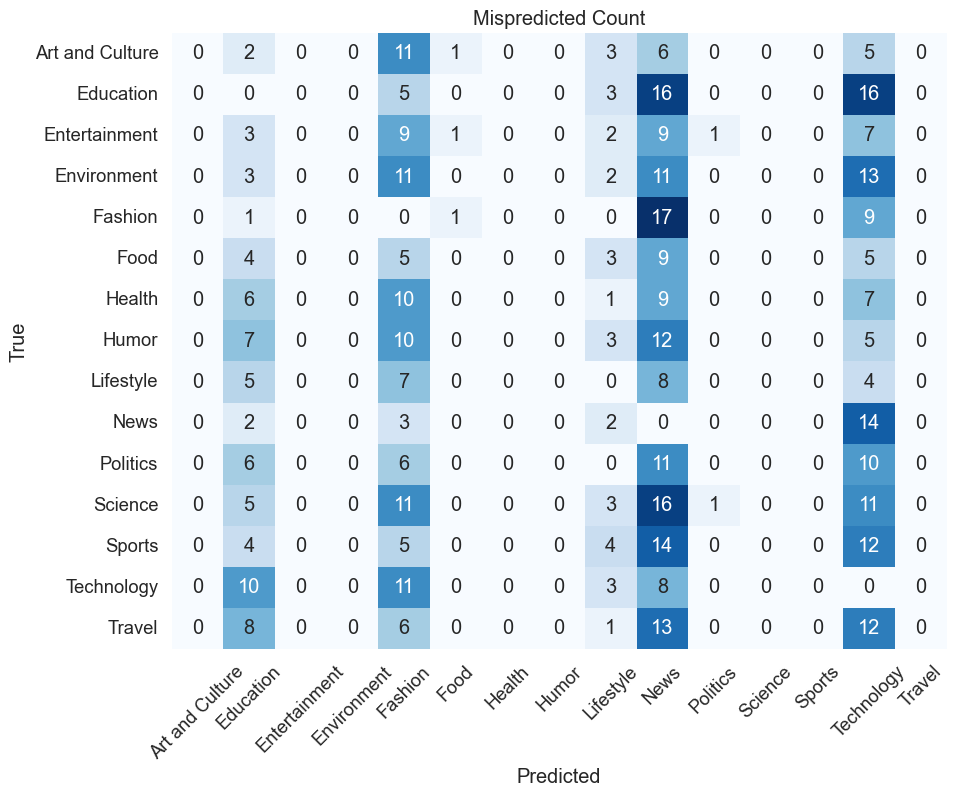

In [299]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(y_test, mlp(torch.tensor(X_test).float()).argmax(dim=1).numpy())
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count')
plt.xticks(rotation=45)
plt.savefig("LSTM test Mispredicted")
plt.show()


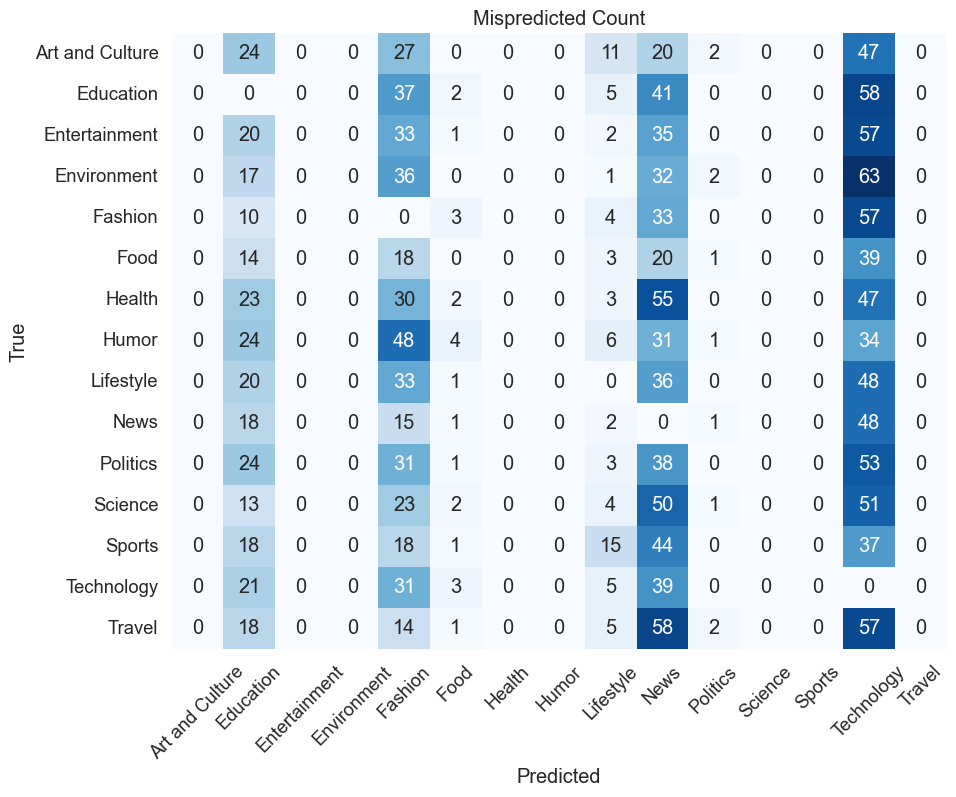

In [300]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(y_train, mlp(torch.tensor(X_train).float()).argmax(dim=1).numpy())
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count')
plt.xticks(rotation=45)
plt.savefig("LSTM train Mispredicted")
plt.show()
